## Import Libraries

In [ ]:
%pip install transformers
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
import transformers
#from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.7 MB/s 
     |████████████████████████████████| 120 kB 47.2 MB/s 
     |████████████████████████████████| 6.6 MB 16.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## Load and Preprocess Training Data

Dataset will be tokenized then split into training and validation sets. The validation set will be used to monitor training. For testing a separate test set will be loaded for analysis.

In [ ]:
filepath="/content/drive/MyDrive/dataset/rawdata3.csv"
#df = open(filepath,encoding="utf-8",errors="ignore")
df=pd.read_csv(filepath,encoding="utf-8") #jigsaw-toxic-comment-classification-challenge
df.head()

,id,comment_text,implementation,architecture,requirements,application_domain_knowledge,execution_platform,design,structure,behavior,data_model_information,development_process_tools,user_interface
0,0,the main platform is a vacuum chamber on which...,0,0,1,0,0,0,0,0,0,0,0
1,1,the electron beam is mainly used for imaging,0,0,1,0,0,0,0,0,0,0,0
2,2,electrons generated in the gun unit at the top...,0,0,1,0,0,0,0,0,0,0,0
3,3,by means of an electron deflection system that...,0,0,1,0,0,0,0,0,0,0,0
4,4,the primary beam has interaction with the samp...,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
print('Unique comments: ', df.comment_text.nunique() == df.shape[0])
print('Null values: ', df.isnull().values.any())
# df[df.isna().any(axis=1)]

Unique comments:  False
Null values:  False


In [ ]:
%pip install stanfordnlp
import stanfordnlp
torch.backends.cudnn.enabled=False
stanfordnlp.download("en")
nlp = stanfordnlp.Pipeline(processors='tokenize,pos,depparse,lemma')
s="It is just some random test."
doc = nlp(s)
print(*[f'word: {word.text+" "}\txpos: {word.xpos}' for sent in doc.sentences for word in sent.words], sep='\n')
torch.backends.cudnn.enabled=True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 158 kB 4.7 MB/s 
Using the default treebank "en_ewt" for language "en".
Would you like to download the models for: en_ewt now? (Y/n)
Y

Default download directory: /root/stanfordnlp_resources
Hit enter to continue or type an alternate directory.


Download location: /root/stanfordnlp_resources/en_ewt_models.zip


100%|██████████| 235M/235M [00:41<00:00, 5.71MB/s]



Download complete.  Models saved to: /root/stanfordnlp_resources/en_ewt_models.zip
Extracting models file for: en_ewt
Cleaning up...Done.
Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': '/root/stanfordnlp_resources/en_ewt_models/en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/root/stanfordnlp_resources/en_ewt_models/en_ewt_tagger.pt', 'pretrain_path': '/root/stanfordnlp_resources/en_ewt_models/en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: depparse
With settings: 
{'model_path': '/root/stanfordnlp_resources/en_ewt_models/en_ewt_parser.pt', 'pretrain_path': '/root/stanfordnlp_resources/en_ewt_models/en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/root/stanfordnlp_resources/en_ewt_models/en_ewt_lemmatizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}


/usr/local/lib/python3.7/dist-packages/stanfordnlp/models/depparse/model.py:157: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:1239.)
  unlabeled_scores.masked_fill_(diag, -float('inf'))


In [ ]:
#check if the sentence is passive(passive verb exits)
def _is_passive(tokens):
  for tok in tokens:
    if(tok.dep_ == "auxpass"):
      return True
  return False

In [ ]:
# if auxiliary verbs
def _is_non_aux_verb(tok):
  return tok.pos_ == "VERB" and (tok.dep_ != "aux" and tok.dep_ != "auxpass")

In [ ]:
#if verb
def _is_verb(tok):
  return tok.pos_ == "VERB" or tok.pos_ == "AUX"

In [ ]:
#find the verb
def _find_verbs(tokens):
  verbs = [tok for tok in tokens if _is_non_aux_verb(tok)]
  if(len(verbs) == 0):
    verbs = [tok for tok in tokens if _is_verb(tok)]
  return verbs

In [ ]:
# does dependency set contain any coordinating conjunctions?
def contains_conj(depSet):
  return "and" in depSet or "or" in depSet or "nor" in depSet or "but" in depSet or "yet" in depSet or "so" in depSet or "for" in depSet

In [ ]:
SUBJECTS = {"nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"}
# get subs joined by conjunctions
def _get_subs_from_conjunctions(subs):
  more_subs = []
  for sub in subs:
    # rights is a generator
    rights = list(sub.rights)
    rightDeps = {tok.lower_ for tok in rights}
    if contains_conj(rightDeps):
      more_subs.extend([tok for tok in rights if tok.dep_ in SUBJECTS or tok.pos_ == "NOUN"])
      if(len(more_subs))> 0:
        more_subs.extend(_get_subs_from_conjunctions(more_subs))
  return more_subs

In [ ]:
# is the tok set's left or right negated?
NEGATIONS = {"no", "not", "n't", "never", "none"}
def _is_negated(tok):
  parts = list(tok.lefts) + list(tok.rights)
  for dep in parts:
    if(dep.lower_ in NEGATIONS):
      return True
  return False

In [ ]:
# find sub dependencies
def _find_subs(tok):
  head = tok.head
  while(head.pos_ != "VERB" and head.pos_ != "NOUN" and head.head != head):
    head = head.head
  if(head.pos_ == "VERB"):
    subs = [tok for tok in head.lefts if tok.dep_ == "SUB"]
    if(len(subs) > 0):
      verb_negated = _is_negated(head)
      subs.extend(_get_subs_from_conjunctions(subs))
      return subs, verb_negated
    elif(head.head != head):
      return _find_subs(head)
  elif(head.pos_ == "NOUN"):
    return [head], _is_negated(tok)
  return [], False

In [ ]:
OBJECTS = {"dobj", "dative", "attr", "oprd"}
# get objects joined by conjunctions
def _get_objs_from_conjunctions(objs):
  more_objs = []
  for obj in objs:
    # rights is a generator
    rights = list(obj.rights)
    rightDeps = {tok.lower_ for tok in rights}
    if(contains_conj(rightDeps)):
      more_objs.extend([tok for tok in rights if tok.dep_ in OBJECTS or tok.pos_ == "NOUN"])
      if(len(more_objs) > 0):
        more_objs.extend(_get_objs_from_conjunctions(more_objs))
  return more_objs

In [ ]:
# get grammatical objects for a given set of dependencies (including passive sentences)
def _get_objs_from_prepositions(deps, is_pas):
  objs = []
  for dep in deps:
    if(dep.pos_ == "ADP" and (dep.dep_ == "prep" or (is_pas and dep.dep_ == "agent"))):
      objs.extend([tok for tok in dep.rights if tok.dep_  in OBJECTS or (tok.pos_ == "PRON" and tok.lower_ == "me") or (is_pas and tok.dep_ == 'pobj')])
  return objs

In [ ]:
# get objects from the dependencies using the attribute dependency
def _get_objs_from_attrs(deps, is_pas):
  for dep in deps:
    if dep.pos_ == "NOUN" and dep.dep_ == "attr":
      verbs = [tok for tok in dep.rights if tok.pos_ == "VERB"]
      if(len(verbs) > 0):
        for v in verbs:
          rights = list(v.rights)
          objs = [tok for tok in rights if tok.dep_ in OBJECTS]
          objs.extend(_get_objs_from_prepositions(rights, is_pas))
          if(len(objs) > 0):
            return v, objs
  return None, None

In [ ]:
# xcomp; open complement - verb has no suject
def _get_obj_from_xcomp(deps, is_pas):
  for dep in deps:
    if(dep.pos_ == "VERB" and dep.dep_ == "xcomp"):
      v = dep
      rights = list(v.rights)
      objs = [tok for tok in rights if tok.dep_ in OBJECTS]
      objs.extend(_get_objs_from_prepositions(rights, is_pas))
      if(len(objs) > 0):
        return v, objs
  return None, None

In [ ]:
# find the main verb - or any aux verb if we can't find it
def _find_verbs(tokens):
  verbs = [tok for tok in tokens if _is_non_aux_verb(tok)]
  if(len(verbs) == 0):
    verbs = [tok for tok in tokens if _is_verb(tok)]
  return verbs

In [ ]:
# return the verb to the right of this verb in a CCONJ relationship if applicable
def _right_of_verb_is_conj_verb(v):
  # rights is a generator
  rights = list(v.rights)
  # VERB CCONJ VERB
  if(len(rights) > 1 and rights[0].pos_ == 'CCONJ'):
    for tok in rights[1:]:
      if(_is_non_aux_verb(tok)):
        return True, tok
  return False, v

In [ ]:
# get all functional subjects adjacent to the verb passed in
def _get_all_subs(v):
  verb_negated = _is_negated(v)
  subs = [tok for tok in v.lefts if tok.dep_ in SUBJECTS and tok.pos_ != "DET"]
  if len(subs) > 0:
    subs.extend(_get_subs_from_conjunctions(subs))
  else:
    foundSubs, verb_negated = _find_subs(v)
    subs.extend(foundSubs)
  return subs, verb_negated

In [ ]:
# get all objects for an active/passive sentence
def _get_all_objs(v, is_pas):
  # rights is a generator
  rights = list(v.rights)

  objs = [tok for tok in rights if tok.dep_ in OBJECTS or (is_pas and tok.dep_ == 'pobj')]
  objs.extend(_get_objs_from_prepositions(rights, is_pas))
  potential_new_verb, potential_new_objs = _get_obj_from_xcomp(rights, is_pas)
  if(potential_new_verb is not None and potential_new_objs is not None and len(potential_new_objs) > 0):
    objs.extend(potential_new_objs)
    v = potential_new_verb
  if(len(objs) > 0):
    objs.extend(_get_objs_from_conjunctions(objs))
  return v, objs

In [ ]:
# resolve a 'that' where/if appropriate
def _get_that_resolution(toks):
  for tok in toks:
    if('that' in [t.orth_ for t in tok.lefts]):
      return tok.head
  return None

In [ ]:
# simple stemmer using lemmas
def _get_lemma(word: str):
  tokens = nlp(word)
  if len(tokens) == 1:
    return tokens[0].lemma_
  return word

In [ ]:
# print information for displaying all kinds of things of the parse tree
def printDeps(toks):
  for tok in toks:
    print(tok.orth_, tok.dep_, tok.pos_, tok.head.text, [t.orth_ for t in tok.lefts], [t.orth_ for t in tok.rights])


In [ ]:
BREAKER_POS = {"CCONJ", "VERB"}
# expand an obj / subj np using its chunk
def expand(item, tokens, visited):
  if(item.lower_ == 'that'):
    temp_item = _get_that_resolution(tokens)
    if(temp_item is not None):
      item = temp_item

  parts = []

  if(hasattr(item, 'lefts')):
    for part in item.lefts:
      if(part.pos_ in BREAKER_POS):
        break
      if(not part.lower_ in NEGATIONS):
        parts.append(part)

  parts.append(item)

  if(hasattr(item, 'rights')):
    for part in item.rights:
      if(part.pos_ in BREAKER_POS):
        break
      if(not part.lower_ in NEGATIONS):
        parts.append(part)

  if(hasattr(parts[-1], 'rights')):
    for item2 in parts[-1].rights:
      if(item2.pos_ == "DET" or item2.pos_ == "NOUN"):
        if(item2.i not in visited):
          visited.add(item2.i)
          parts.extend(expand(item2, tokens, visited))
      break

  return parts

In [ ]:
# convert a list of tokens to a string
from collections.abc import Iterable
def to_str(tokens):
  if(isinstance(tokens, Iterable)):
    return ' '.join([item.orth_ for item in tokens])
  else:
    return ''

In [ ]:
# get all the verbs on tokens with negation marker
def _find_svs(tokens):
  svs = []
  verbs = [tok for tok in tokens if tok.pos_ == "VERB"]
  for v in verbs:
    subs, verbNegated = _get_all_subs(v)
    if(len(subs) > 0):
      for sub in subs:
        svs.append((sub.orth_, "!" + v.orth_ if verbNegated else v.orth_))
  return svs

In [ ]:
# find verbs and their subjects / objects to create SVOs, detect passive/active sentences
def findSVOs(tokens):
  svos = []
  is_pas = _is_passive(tokens)
  verbs = _find_verbs(tokens)
  visited = set()  # recursion detection
  for v in verbs:
    subs, verbNegated = _get_all_subs(v)
    # hopefully there are subs, if not, don't examine this verb any longer
    if(len(subs) > 0):
      isConjVerb, conjV = _right_of_verb_is_conj_verb(v)
      if(isConjVerb):
        v2, objs = _get_all_objs(conjV, is_pas)
        for sub in subs:
          for obj in objs:
            objNegated = _is_negated(obj)
            if(is_pas):  # reverse object / subject for passive
              svos.append((to_str(expand(obj, tokens, visited)),"!" + v.lemma_ if verbNegated or objNegated else v.lemma_, to_str(expand(sub, tokens, visited))))
              svos.append((to_str(expand(obj, tokens, visited)),"!" + v2.lemma_ if verbNegated or objNegated else v2.lemma_, to_str(expand(sub, tokens, visited))))
            else:
              svos.append((to_str(expand(sub, tokens, visited)),"!" + v.lower_ if verbNegated or objNegated else v.lower_, to_str(expand(obj, tokens, visited))))
              svos.append((to_str(expand(sub, tokens, visited)),"!" + v2.lower_ if verbNegated or objNegated else v2.lower_, to_str(expand(obj, tokens, visited))))
      else:
        v, objs = _get_all_objs(v, is_pas)
        for sub in subs:
          if(len(objs) > 0):
            for obj in objs:
              objNegated = _is_negated(obj)
              if(is_pas):  
                svos.append((to_str(expand(obj, tokens, visited)),"!" + v.lemma_ if verbNegated or objNegated else v.lemma_, to_str(expand(sub, tokens, visited))))
              else:
                svos.append((to_str(expand(sub, tokens, visited)),"!" + v.lower_ if verbNegated or objNegated else v.lower_, to_str(expand(obj, tokens, visited))))
          else:
            svos.append((to_str(expand(sub, tokens, visited)),"!" + v.lower_ if verbNegated else v.lower_,))

  return svos

In [ ]:
import en_core_web_sm

In [ ]:
!pip install git+https://github.com/mmxgn/spacy-clausie.git
import spacy
import claucy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/mmxgn/spacy-clausie.git to /tmp/pip-req-build-lf_w8fyr
  Running command git clone -q https://github.com/mmxgn/spacy-clausie.git /tmp/pip-req-build-lf_w8fyr
     |████████████████████████████████| 769 kB 4.8 MB/s 
  Created wheel for claucy: filename=claucy-0.0.2.0-py3-none-any.whl size=7214 sha256=b3e1f55938667bb582f2ea6d24f81a081dabc0472e4b452699cbbe2ebd77d814
  Stored in directory: /tmp/pip-ephem-wheel-cache-dtp4dk92/wheels/80/50/95/d1c36e8958570bf2e208899eba20671f8ada3c1e98deffe8f2
Successfully built claucy


In [ ]:
nlp = en_core_web_sm.load()
claucy.add_to_pipe(nlp)
tok = nlp('A command-line interface is also available, especially aimed for managing SPHERE.IO user accounts and projects from a command-line shell.')
#print(tok._.clauses)
try:
  propositions = tok._.clauses[0].to_propositions(as_text=True)
except:
  propositions = []
print(propositions[0])
svos = findSVOs(nlp(propositions[0]))
print(svos)

A command - line interface is available
[('A line interface', 'is')]


In [ ]:
import openpyxl
wb = openpyxl.Workbook()
sheet = wb.active
sheet.title= 'svo'
wb.save('svo.xlsx')
wb = openpyxl.load_workbook('svo.xlsx')
sheet = wb.active
#sheet.cell(row=1, column=1).value = 'TEST'
#wb.save('svo.xlsx')

In [ ]:
counters1=-1
counters2=2
sheet.cell(row=1,column=1).value = 'ID'
sheet.cell(row=1,column=2).value = 'sentences'
sheet.cell(row=1,column=3).value = 'subject'
sheet.cell(row=1,column=4).value = 'verb'
sheet.cell(row=1,column=5).value = 'object'
wb.save('svo.xlsx')     

In [ ]:
rows = df['comment_text']
set_raw = list(rows[0:])
results_svo=[]
counters=0
sheet = wb.active
for tokens in set_raw:
  counters1=counters1+1
  #claucy.add_to_pipe(nlp)
  tok = nlp(tokens)
  if(len(tok._.clauses)>0):
    #print(tok._.clauses)
    try:
      propositions = tok._.clauses[0].to_propositions(as_text=True)
      for i in range(len(propositions)):
        toks=nlp(propositions[i])
        svos = findSVOs(toks)
        for svo_result in svos:
          #print(set_raw[counters1])
          sheet.cell(row=counters2,column=1).value = counters1
          sheet.cell(row=counters2,column=2).value = set_raw[counters1]
          if(len(svo_result)>2):
            sheet.cell(row=counters2,column=3).value = svo_result[0]
            sheet.cell(row=counters2,column=4).value = svo_result[1]
            sheet.cell(row=counters2,column=5).value = svo_result[2]
          elif(len(svo_result)==2):
            sheet.cell(row=counters2,column=3).value = svo_result[0]
            sheet.cell(row=counters2,column=4).value = svo_result[1]
          else:
            sheet.cell(row=counters2,column=4).value = svo_result[0]
          counters2=counters2+1
    except:
      toks=tok
      svos = findSVOs(toks)
      for svo_result in svos:
        #print(set_raw[counters1])
        sheet.cell(row=counters2,column=1).value = counters1
        sheet.cell(row=counters2,column=2).value = set_raw[counters1]
        if(len(svo_result)>2):
          sheet.cell(row=counters2,column=3).value = svo_result[0]
          sheet.cell(row=counters2,column=4).value = svo_result[1]
          sheet.cell(row=counters2,column=5).value = svo_result[2]
        elif(len(svo_result)==2):
          sheet.cell(row=counters2,column=3).value = svo_result[0]
          sheet.cell(row=counters2,column=4).value = svo_result[1]
        else:
          sheet.cell(row=counters2,column=4).value = svo_result[0]
        counters2=counters2+1
  else:
    toks=tok
    svos = findSVOs(toks)
    for svo_result in svos:
      #print(set_raw[counters1])
      sheet.cell(row=counters2,column=1).value = counters1
      sheet.cell(row=counters2,column=2).value = set_raw[counters1]
      if(len(svo_result)>2):
        sheet.cell(row=counters2,column=3).value = svo_result[0]
        sheet.cell(row=counters2,column=4).value = svo_result[1]
        sheet.cell(row=counters2,column=5).value = svo_result[2]
      elif(len(svo_result)==2):
        sheet.cell(row=counters2,column=3).value = svo_result[0]
        sheet.cell(row=counters2,column=4).value = svo_result[1]
      else:
        sheet.cell(row=counters2,column=4).value = svo_result[0]
      counters2=counters2+1
  #print(counters)
  if(svos==[]):
    svos=[('fill','fill')]
    svos = findSVOs(toks)
    for svo_result in svos:
      #print(set_raw[counters1])
      sheet.cell(row=counters2,column=1).value = counters1
      sheet.cell(row=counters2,column=2).value = set_raw[counters1]
      if(len(svo_result)>2):
        sheet.cell(row=counters2,column=3).value = svo_result[0]
        sheet.cell(row=counters2,column=4).value = svo_result[1]
        sheet.cell(row=counters2,column=5).value = svo_result[2]
      elif(len(svo_result)==2):
        sheet.cell(row=counters2,column=3).value = svo_result[0]
        sheet.cell(row=counters2,column=4).value = svo_result[1]
      else:
        sheet.cell(row=counters2,column=4).value = svo_result[0]
      counters2=counters2+1
  results_svo.append(svos)
  counters=counters+1
wb.save('svo.xlsx')
print(counters)

2068


In [ ]:
print(counters2)

3692


In [ ]:
temp=''
temp_counter=0
temp1=''
temp_counter1=0
for i in range(1,counters2-1):
  cell1=sheet.cell(i+1,3).value
  cell2=sheet.cell(i+1,5).value
  tok = nlp(cell1)
  for doc in tok:
    #print(doc.pos_)
    if(doc.pos_ == 'NOUN'):
      if(temp_counter==0):
        temp=temp+str(doc)
        temp_counter=temp_counter+1
      else:
        temp=temp+' '+str(doc)
        temp_counter=temp_counter+1
  if(temp!=''):
    sheet.cell(i+1,3).value=temp
  #print(temp)
  temp=''
  temp_counter=0
  if(cell2!=None):
    tok1 = nlp(cell2)
    for doc1 in tok1:
      #print(doc1.pos_)
      if(doc1.pos_ == 'NOUN'):
        if(temp_counter1==0):
          temp1=temp1+str(doc1)
          temp_counter1=temp_counter1+1
        else:
          temp1=temp1+' '+str(doc1)
          temp_counter1=temp_counter1+1
    if(temp1!=''):
      sheet.cell(i+1,5).value=temp1
  #print(temp1)
  temp1=''
  temp_counter1=0


In [ ]:
wb.save('svo.xlsx')

In [ ]:
from google.colab import files
files.download('svo.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

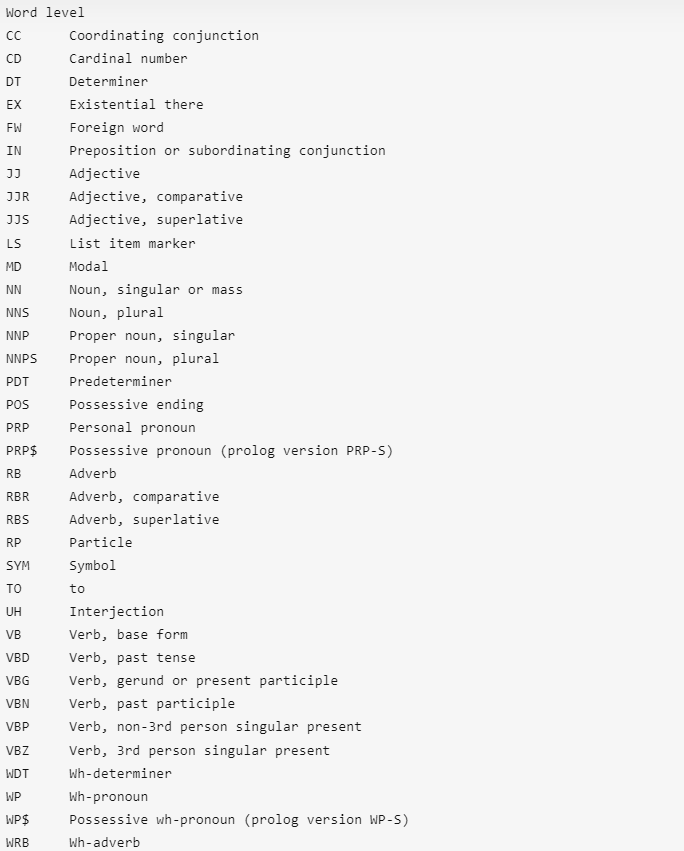

In [ ]:
import spacy
eng_model = spacy.load("en_core_web_sm")
rows = df['comment_text']
sentences_original = list(rows[0:100])
new_list=list()
sent1=''
number=0
for sent in sentences_original:
  sentences_extract = eng_model(sent)
  for ent in sentences_extract.ents:
    print(ent,ent.label_)
    sent1=''.join(sent.split(str(ent)))
  number=number+1
  print("sentence number:",number)
  new_list.append(sent1)
#print(new_list[0:4])
#df['comment_text'] = new_list
#print('sentence columns: ', sentences_original)

sentence number: 1
sentence number: 2
sentence number: 3
sentence number: 4
secondary ORDINAL
sentence number: 5
sentence number: 6
sentence number: 7
sentence number: 8
sentence number: 9
sentence number: 10
sentence number: 11
sentence number: 12
sentence number: 13
sentence number: 14
52 CARDINAL
sentence number: 15
sentence number: 16
sentence number: 17
first ORDINAL
sentence number: 18
sentence number: 19
nova LOC
sentence number: 20
sentence number: 21
sentence number: 22
sentence number: 23
sentence number: 24
sentence number: 25
1 CARDINAL
nova LOC
sentence number: 26
sentence number: 27
first ORDINAL
two CARDINAL
sentence number: 28
sentence number: 29
sentence number: 30
sentence number: 31
sentence number: 32
sentence number: 33
sentence number: 34
sentence number: 35
sentence number: 36
sentence number: 37
sentence number: 38
sentence number: 39
sentence number: 40
sentence number: 41
one CARDINAL
sentence number: 42
1 CARDINAL
sentence number: 43
sentence number: 44
sente

In [ ]:
print('average sentence length: ', df.comment_text.str.split().str.len().mean())
print('stdev sentence length: ', df.comment_text.str.split().str.len().std())

average sentence length:  20.959381044487426
stdev sentence length:  11.620648506079869


In [ ]:
cols = df.columns
label_cols = list(cols[2:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['implementation', 'architecture', 'requirements', 'application_domain_knowledge', 'execution_platform', 'design', 'structure', 'behavior', 'data_model_information', 'development_process_tools', 'user_interface']


In [ ]:
print('Count of 1 per label: \n', df[label_cols].sum(), '\n') # Label counts, may need to downsample or upsample
print('Count of 0 per label: \n', df[label_cols].eq(0).sum())

Count of 1 per label: 
 implementation                  339
architecture                    184
requirements                    480
application_domain_knowledge     70
execution_platform              118
design                          106
structure                       152
behavior                        666
data_model_information           12
development_process_tools        81
user_interface                   95
dtype: int64 

Count of 0 per label: 
 implementation                  1729
architecture                    1884
requirements                    1588
application_domain_knowledge    1998
execution_platform              1950
design                          1962
structure                       1916
behavior                        1402
data_model_information          2056
development_process_tools       1987
user_interface                  1973
dtype: int64


In [ ]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle rows

In [ ]:
df['one_hot_labels'] = list(df[label_cols].values)
df.head()

,id,comment_text,implementation,architecture,requirements,application_domain_knowledge,execution_platform,design,structure,behavior,data_model_information,development_process_tools,user_interface,one_hot_labels
0,111,supplier capabilities: alignment with the (mec...,0,0,0,0,0,0,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
1,586,Especially for wind tunnels that are in high d...,0,0,1,0,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,1920,The query language XPath is used to select the...,1,0,0,0,1,0,0,0,0,0,0,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
3,881,"However, it is advised that they do monitor ac...",0,0,1,0,0,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]"
4,2041,"As a registered customer, I want to remove a p...",0,0,1,0,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
labels = list(df.one_hot_labels.values)
comments = list(df.comment_text.values)

Load the pretrained tokenizer that corresponds to your choice in model. e.g.,

```
BERT:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

XLNet:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 

RoBERTa:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
```


In order to avoid memory issues with Google Colab, I enforce a max_length of 100 tokens. Note that some sentences may not adequately represent each label because of this.

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
max_length = 100
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer
encodings = tokenizer.batch_encode_plus(comments,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks
#print(attention_masks)

In [ ]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [1623, 933, 647]


In [ ]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

Be sure to handle all classes during validation using "stratify" during train/validation split:

In [ ]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                                                            random_state=2020, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
train_token_types.extend(one_freq_token_types)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

## Load Model & Set Params

Load the appropriate model below, each model already contains a single dense layer for classification on top.



```
BERT:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

XLNet:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)

RoBERTa:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
```



In [ ]:
from transformers import BertForSequenceClassification
# Load model, the pretrained model will include a single linear classification layer on top for classification. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Setting custom optimization parameters for the AdamW optimizer https://huggingface.co/transformers/main_classes/optimizer_schedules.html

In [ ]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
from torch.optim import AdamW
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimization

## Train Model

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss() 
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss() 
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())    

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.45400803422523756


Epoch:  10%|█         | 1/10 [00:32<04:50, 32.32s/it]

F1 Validation Accuracy:  0.0
Flat Validation Accuracy:  14.975845410628018
Train loss: 0.2941702033503581


Epoch:  20%|██        | 2/10 [01:04<04:16, 32.07s/it]

F1 Validation Accuracy:  0.0
Flat Validation Accuracy:  14.975845410628018
Train loss: 0.27818725775864167


Epoch:  30%|███       | 3/10 [01:35<03:43, 31.94s/it]

F1 Validation Accuracy:  3.404255319148936
Flat Validation Accuracy:  14.975845410628018
Train loss: 0.2506412270210557


Epoch:  40%|████      | 4/10 [02:07<03:10, 31.70s/it]

F1 Validation Accuracy:  35.256410256410255
Flat Validation Accuracy:  29.468599033816425
Train loss: 0.22291208525835457


Epoch:  50%|█████     | 5/10 [02:38<02:38, 31.65s/it]

F1 Validation Accuracy:  45.614035087719294
Flat Validation Accuracy:  37.19806763285024
Train loss: 0.19056788642527694


Epoch:  60%|██████    | 6/10 [03:10<02:06, 31.66s/it]

F1 Validation Accuracy:  42.565597667638485
Flat Validation Accuracy:  34.29951690821256
Train loss: 0.15931596392292088


Epoch:  70%|███████   | 7/10 [03:42<01:34, 31.65s/it]

F1 Validation Accuracy:  52.083333333333336
Flat Validation Accuracy:  42.51207729468599
Train loss: 0.1328742554632284


Epoch:  80%|████████  | 8/10 [04:13<01:03, 31.62s/it]

F1 Validation Accuracy:  52.26130653266331
Flat Validation Accuracy:  41.06280193236715
Train loss: 0.11179371973720648


Epoch:  90%|█████████ | 9/10 [04:45<00:31, 31.60s/it]

F1 Validation Accuracy:  53.36658354114713
Flat Validation Accuracy:  43.96135265700483
Train loss: 0.09430232915585324


Epoch: 100%|██████████| 10/10 [05:16<00:00, 31.69s/it]

F1 Validation Accuracy:  51.6795865633075
Flat Validation Accuracy:  41.06280193236715


In [ ]:
torch.save(model.state_dict(), 'bert_model_toxic')

## Load and Preprocess Test Data

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/dataset/test.csv")
#test_labels_df = pd.read_csv('test_labels.csv')
#test_df = test_df.merge(test_labels_df, on='id', how='left')
test_label_cols = list(test_df.columns[2:])
#print('Null values: ', test_df.isnull().values.any()) #should not be any null sentences or labels
#print('Same columns between train and test: ', label_cols == test_label_cols) #columns should be the same
test_df.head()

,id,comment_text,implementation,architecture,requirements,application_domain_knowledge,execution_platform,design,structure,behavior,data_model_information,development_process_tools,user_interface
0,1,the versatility of the instrument including al...,0,0,0,0,0,0,0,0,0,0,0
1,2,several systems are defined serving these appl...,0,0,0,1,0,0,0,0,0,0,0
2,3,the samples do not need any preparation and co...,0,0,1,0,0,0,0,0,0,0,0
3,4,with its tungsten source tip (lifetime 40 hour...,0,0,0,0,0,0,0,0,0,0,0
4,5,nova nanolab: this system is equipped with a h...,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
test_df = test_df[~test_df[test_label_cols].eq(-1).any(axis=1)] #remove irrelevant rows/comments with -1 values
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)
test_df.head()

,id,comment_text,implementation,architecture,requirements,application_domain_knowledge,execution_platform,design,structure,behavior,data_model_information,development_process_tools,user_interface,one_hot_labels
0,1,the versatility of the instrument including al...,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,2,several systems are defined serving these appl...,0,0,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
2,3,the samples do not need any preparation and co...,0,0,1,0,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,4,with its tungsten source tip (lifetime 40 hour...,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,5,nova nanolab: this system is equipped with a h...,0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


In [ ]:
# Gathering input data
test_labels = list(test_df.one_hot_labels.values)
test_comments = list(test_df.comment_text.values)

In [ ]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_comments,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

## Prediction and Metics

In [ ]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

We need to threshold our sigmoid function outputs which range from [0, 1]. Below I use 0.50 as a threshold.

In [ ]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Test F1 Accuracy:  0.42400000000000004
Test Flat Accuracy:  0.40069686411149824 

                              precision    recall  f1-score   support

              implementation       0.17      0.67      0.27         9
                architecture       1.00      0.25      0.40        48
                requirements       0.89      0.58      0.70        88
application_domain_knowledge       0.00      0.00      0.00        13
          execution_platform       1.00      1.00      1.00         1
                      design       0.00      0.00      0.00        25
                   structure       1.00      0.25      0.40        65
                    behavior       0.33      0.32      0.32        53
      data_model_information       0.00      0.00      0.00         2
   development_process_tools       0.00      0.00      0.00         4
              user_interface       0.25      0.43      0.32         7

                   micro avg       0.57      0.34      0.42       315
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
